<h3>importing libraries</h3>

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

c:\Users\alita\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h5>read data and explore it </h5>

In [2]:
data=pd.read_csv("Your_data.csv")
data.drop(data.columns[0], axis=1,inplace=True)
data.head(3)
data.info()
print(str(data.isnull().sum()))
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   eyesight(left)    159256 non-null  float64
 1   systolic          159256 non-null  int64  
 2   serum creatinine  159256 non-null  float64
 3   triglyceride      159256 non-null  int64  
 4   Cholesterol       159256 non-null  int64  
 5   AST               159256 non-null  int64  
 6   height(cm)        159256 non-null  int64  
 7   waist(cm)         159256 non-null  float64
 8   age               159256 non-null  int64  
 9   LDL               159256 non-null  int64  
 10  smoking           159256 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 13.4 MB
eyesight(left)      0
systolic            0
serum creatinine    0
triglyceride        0
Cholesterol         0
AST                 0
height(cm)          0
waist(cm)           0
age                 0
LDL             

<h4> data split in train , test and validataion</h4>

In [3]:

X=data.drop('smoking', axis=1)
Y = data['smoking']
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data['smoking'])
X_train=train_data.drop(['smoking'],axis=1)
Y_train=train_data['smoking']
print(data.shape)

(159256, 11)


<h3>feature selection</h3>
<p>information gain when ig of a feature increases it decrease uncertainlity</p>

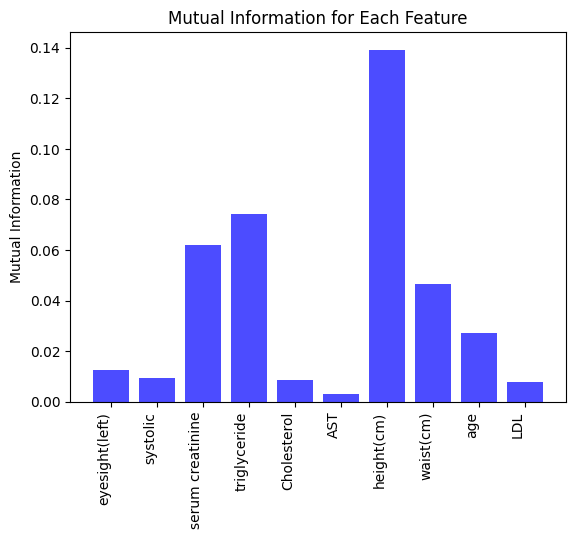

In [4]:
from sklearn.feature_selection import mutual_info_classif

ig=mutual_info_classif(X_train,Y_train)
plt.bar(np.arange(X_train.shape[1]), ig, color='blue', alpha=0.7)

plt.ylabel('Mutual Information')
plt.title('Mutual Information for Each Feature')

# Add feature names under each bar
plt.xticks(np.arange(X_train.shape[1]), X_train.columns, rotation=90, ha='right')

plt.show()

In [5]:
# height and triglyceride and serum creatinine because they have high information gain

# <h2>VarianceThreshold</h2>
# <h4>Remove elements with zero variance (constant values)</h4>

In [9]:
from sklearn.feature_selection import VarianceThreshold
variance_obj =  VarianceThreshold(threshold = 0)
variance_obj.fit(X_scaled)

Index(['eyesight(left)', 'systolic', 'serum creatinine', 'triglyceride',
       'Cholesterol', 'AST', 'height(cm)', 'waist(cm)', 'age', 'LDL',
       'smoking'],
      dtype='object')
Index(['triglyceride', 'Cholesterol', 'age', 'smoking'], dtype='object')


In [47]:
X=data.drop('smoking', axis=1)
Y = data['smoking']
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data['smoking'])

# <h3>See if there are any features with zero variance</h3>
# <h4>True means not ZERO variance and False means ZERO variance and we should drop it</h4>

In [ ]:
variance_obj.get_support()

<h3> remove outliers from train data by percentile</h3>
<p> test age feature</p>

In [48]:

max_threshold=train_data['age'].quantile(1)
min_threshold=train_data['age'].quantile(0)
print(max_threshold,min_threshold)
#all ages are possible ages of smokers won't remove any

85.0 20.0


<p> test LDL feature</p>

In [49]:
max_threshold = train_data['LDL'].quantile(0.999)
min_threshold = train_data['LDL'].quantile(0.001)
print(max_threshold,min_threshold)
train_data = train_data[(train_data['LDL'] < max_threshold) & (train_data['LDL'] > min_threshold)]

print(train_data.shape)

202.0 42.0
(111249, 11)


In [50]:
#test AST

In [51]:
max_threshold = train_data['AST'].quantile(0.9999)
min_threshold = train_data['AST'].quantile(0.0001)
print(max_threshold,min_threshold)
train_data = train_data[(train_data['AST'] < max_threshold) & (train_data['AST'] > min_threshold)]

print(train_data.shape)

187.87679999995453 9.0
(111221, 11)


In [52]:
max_threshold = train_data['serum creatinine'].quantile(0.9999)
min_threshold = train_data['serum creatinine'].quantile(0.0001)
print(max_threshold,min_threshold)
train_data = train_data[(train_data['serum creatinine'] < max_threshold) & (train_data['serum creatinine'] > min_threshold)]

print(train_data.shape)

1.987799999998242 0.1122
(111197, 11)


<p> test chelosterol feature</p>

In [53]:
max_threshold = train_data['Cholesterol'].quantile(0.999)
min_threshold = train_data['Cholesterol'].quantile(0.001)
print(max_threshold,min_threshold)
train_data = train_data[(train_data['Cholesterol'] < max_threshold) & (train_data['Cholesterol'] > min_threshold)]

print(train_data.shape)

283.0 118.0
(110963, 11)


<p>test systolic feature</p>

In [54]:
max_threshold = train_data['systolic'].quantile(0.999)
min_threshold = train_data['systolic'].quantile(0.001)
print(max_threshold,min_threshold)
train_data = train_data[(train_data['systolic'] < max_threshold) & (train_data['systolic'] > min_threshold)]

print(train_data.shape)

170.0 90.0
(110300, 11)


test height feature

In [55]:
max_threshold = train_data['height(cm)'].quantile(0.999)
min_threshold = train_data['height(cm)'].quantile(0.001)
print(max_threshold,min_threshold)
train_data = train_data[(train_data['height(cm)'] < max_threshold) & (train_data['height(cm)'] > min_threshold)]

print(train_data.shape)

185.0 140.0
(108906, 11)


<h3>z score normalization to remove outliers</h3>
<p>  is suited for triglyceride distribution</p>

In [56]:

z_scores = zscore(train_data['triglyceride'])
z_score_threshold = 3
outliers = np.abs(z_scores) > z_score_threshold

train_data = train_data[~outliers]
print(train_data.shape)

(107774, 11)


In [57]:
#hemoglobin
z_scores = zscore(train_data['waist(cm)'])
z_score_threshold = 3
outliers = np.abs(z_scores) > z_score_threshold

train_data = train_data[~outliers]
print(train_data.shape)

(107494, 11)


In [58]:
#eyesight(left)
z_scores = zscore(train_data['eyesight(left)'])
z_score_threshold = 3
outliers = np.abs(z_scores) > z_score_threshold

train_data = train_data[~outliers]
print(train_data.shape)

(107401, 11)


<h3>splitting train,test,validate data into x and y </h3>

In [59]:

X_train=train_data.drop(['smoking'],axis=1)
Y_train=train_data['smoking']
X_test=test_data.drop(['smoking'],axis=1)
Y_test=test_data['smoking']

<h3>data normalization</h3>

In [60]:
normalizer=StandardScaler()
X_train=normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)
X = np.vstack((X_train, X_test))
print(X.shape)
Y = np.concatenate((Y_train.values, Y_test.values))
Y.shape

(155178, 10)


(155178,)

In [61]:
Y_train.value_counts()

smoking
0    60866
1    46535
Name: count, dtype: int64

In [62]:
# Train using stand alone model

In [63]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

scores = cross_val_score(DecisionTreeClassifier(), X, Y, cv=5)
scores

array([0.66677407, 0.66638742, 0.66442196, 0.66714999, 0.67001772])

In [64]:
scores.mean()

0.6669502330694282

In [65]:
# Train using Bagging

In [66]:
from sklearn.ensemble import BaggingClassifier

bag_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(), 
    n_estimators=100, 
    max_samples=0.8, 
    oob_score=True,
    random_state=0
)
bag_model.fit(X_train, Y_train)
bag_model.oob_score_

0.7396672284243163

In [67]:
bag_model.score(X_test, Y_test)

0.7398329740251586

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
Adamodel = AdaBoostClassifier(n_estimators=100 ,learning_rate=1)
model = Adamodel.fit(X_train,Y_train)
y_pred = model.predict(X_test)
print("Accuracy 1 :",metrics.accuracy_score(Y_test,y_pred)) 
# -----------------------------------------------------------
# using logisticRegression 
from sklearn.linear_model import LogisticRegression 
logisticModel = LogisticRegression()
Adamodel_2 = AdaBoostClassifier(n_estimators=50 ,base_estimator=logisticModel,learning_rate=1)
model_2 = Adamodel_2.fit(X_train,Y_train)
y_pred_2 = model_2.predict(X_test)
print("Accuracy 2 :",metrics.accuracy_score(Y_test,y_pred_2)) 

In [ ]:
# Train using Random Forest

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
randomForest = RandomForestClassifier(n_estimators= 100)
randomForestModel = randomForest.fit(X_train,Y_train)
y_pred_0 = randomForestModel.predict(X_test)
# randomForestModel.oob_score_
print("Accuracy  :",metrics.accuracy_score(Y_test,y_pred_0)) 

0.6868572941005613

<h1>GRIDSEARCH</h1>
<h3>GRIDSERACH FOR BaggingClassifier</h3>

In [ ]:
from sklearn.model_selection import GridSearchCV
result = GridSearchCV(
        BaggingClassifier(),
        {
            'estimator': [DecisionTreeClassifier()],
            'n_estimators': [10, 50, 100],
            'max_samples': [0.3, 0.5, 0.8, 0.9],
            'oob_score': [True, False],
            'random_state': [0]
        },
    cv=5,
    return_train_score=False
)

result.fit(X,y)
result.cv_results_

In [ ]:
df = pd.DataFrame(result.cv_results_)
df

In [ ]:
df [['param_n_estimators','params','mean_test_score']]

<h3>Random GridSearch for Bagging</h3>

In [ ]:
from sklearn.model_selection import GridSearchCV
result = RandomizedSearchCV(
        BaggingClassifier(),
        {
            'estimator': [DecisionTreeClassifier()],
            'n_estimators': [10, 50, 100],
            'max_samples': [0.3, 0.5, 0.8, 0.9],
            'oob_score': [True, False],
            'random_state': [0]
        },
    cv=5,
    return_train_score=False
)

result.fit(X,y)
pd.DataFrame(result.cv_results_)[['param_n_estimators','params','mean_test_score']]

<h3>GRIDSERACH FOR RandomForestClassifier</h3>

In [ ]:
from sklearn.model_selection import GridSearchCV
result = GridSearchCV(
    RandomForestClassifier(), {
        'n_estimators': [1,5,10,50]
    },
    cv = 5,return_train_score = False,n_iter =2
)

result.fit(X,y)
result.cv_results_

In [ ]:
df = pd.DataFrame(result.cv_results_)
df

<h3>picking columns from tables to see score</h3>

In [ ]:
df [['param_n_estimators','params','mean_test_score']]

In [ ]:
<h2>getting best score</h2>

In [ ]:
result.best_score_

<h3>getting best parameters</h3>

In [ ]:
result.best_params_

<h2>RANDOMIZED GridSearch</h2>

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
result = RandomizedSearchCV(
    RandomForestClassifier(), {
        'n_estimators': [1,5,10,50]
    },
    cv = 5,return_train_score = False,n_iter =2  #give number of combinations of features
)

result.fit(X,y)
pd.DataFrame(result.cv_results_)[['param_n_estimators','params','mean_test_score']]
